UFRJ/EQ, Agosto de 2018.

# Cálculo de equilíbrio líquido-vapor de substância pura com equação de estado cúbica.

# Introdução

O objetivo dessa aula é apresentar uma metodologia de resolução computacional de equação de estado cúbica.

> Por resolução, entendamos (1) cálculo de pressão a partir de volume e temperatura, (2) cálculo de volume a partir de pressão e temperatura e (3) cálculo de propriedades residuais (entalpia, entropia, energia de Helmholtz, energia de Gibbs).

Além disso, é apresentada uma metodologia para o cálculo de equilíbrio líquido vapor a partir do critério de igualdade de potencial químico do componente em cada fase.

> O critério de equlíbrio é satisfeito utilizando os cálculos de energia de Gibbs residual a partir da equação de estado.

Esta aula se limita ao estudo de substâncias puras.

> São estudadas a relação $P,V,T$ de substância pura em estado líquido ou vapor e em equilíbrio de fases, e a curva univariante de pressão de saturação.

Os cálculos que seguem são realizados utilizado a equação de estado cúbica de Soave para a substância Metano.

> São utilizados o equacionamento e parâmetros apresentados por Reid, Prausnitz & Poling, 1987 e por Smith, van Ness & Abbott, 2007.

>* Vamos trabalhar apenas com propriedades intensivas, portanto convém usar a notação simplificada: $P$ para pressão, $T$ para temperatura, $V$, $H$, $S$, $A$ e $G$ para volume molar, entalpia molar, entropia molar, energia de Helmholtz molar e energia de Gibbs molar.

# Metodologia

Essa aula é dividida nas seguintes etapas:

1. programação $P(T,V)$ usando a equação de Soave (Reid, Prausnitz & Poling, 1987 - pp 42, 43)
  1. cálculo em sequência de $P$ versus sequência de $V$ para dados $T$
  1. desenhar isotermas no plano $P$ versus $V$
1. programação $V(P,T)$ usando método de solução de raiz de polinômios (numpy.roots)
  1. implementar lógica de classificação de raízes de volume (líquido, vapor, intermediária e não física)
  1. comparar calculos pontuais com as isotermas
1. programação de pressão limite superior e inferior para cálculo de equilibrio de fases (baseado em Topliss, Dimitrelis & Prausnitz, 1988)
  1. comparar calculos pontuais com as isotermas
1. programação de energia de gibbs residual (Reid, Prausnitz & Poling, 1987)
  1. cálculo em sequência $G^{\mathrm{RES},L}$ e sequência $G^{\mathrm{RES},V}$ versus sequência $P$ para dado $T$
  1. desenhar $G^{\mathrm{RES},L}$ e $G^{\mathrm{RES},V}$ versus $P$ para dado $T$ e verificar existência de solução para o critério de equilíbrio de fases.
1. programação de resolução da pressão de saturação usando método de bisseção (scipy.optimize.bisect)
    1. cálculo em sequência de pressão de saturação versus sequência de $T$
    1. desenhar $P^\mathrm{SAT}$ versus $T$
1. geração do envelope de fases no plano $P$ versus $V$ (Smith, van Ness & Abbott, 2007)
    1. cálculo em sequência de volumes de líquido e olume de vapor para cada par $(T,P)$ na curva de $P^\mathrm{SAT}$
    1. desenhar envelope de fases no diagrama $P$ versus $V$ com algumas isotermas
1. programação de entalpia e entropia residuais (Reid, Prausnitz & Poling, 1987) - TAREFA
    1. testar pontualmente
1. geração dos envelope de fases nos planos $T$ versus $S^\mathrm{RES}$ e $P$ versus $H^\mathrm{RES}$ (Smith, van Ness & Abbott, 2007)
    1. cálculo em sequência de entalpia e entropia residuais de líquido e de vapor para cada par $(T,P)$ na curva de $P^\mathrm{SAT}$
    1. desenhar envelope de fases no diagrama T versus $S^\mathrm{RES}$ com algumas isóbaras
    1. desenhar envelope de fases no diagrama P versus $H^\mathrm{RES}$ com algumas isotermas

## carregando pacotes utilizados nesta aula:

In [152]:
import numpy as np
#1. arrays (vetores R^n) para cálculos em sequência
#2. resolução de raiz de polinômios (np.roots)

from matplotlib import pyplot as plt
# pacote para desenhar gráficos
%matplotlib inline
# comando para integrar or gráficos no arquivo notebook

from scipy import optimize as opt
# resolução de equação não linear por método de biseção (opt.bisect)

# Implementação, resultados e discussão

## A equação de Soave
é uma equação de estado dada pela expressão de pressão em função de temperatura e volume molar abaixo

$$P=\frac{RT}{V-b}-\frac{a}{V^2+ubV+wb^2}$$

em que

> $u=1$
>
> $w=0$
>
> $b=\frac{0.08664RT_c}{P_c}$
>
> $a=\frac{0.42748R^2T_c^2}{P_c}(1+f(1-(T/T_c)^{(1/2)}))^2$
>
>$f=0.48+1.574\omega-0.176\omega^2$

> Reid, Prausnitz & Poling, 1987 pp 42, 43

Nota-se que sua parametrização ($a$,$b$) é dada em função de propriedades do componente (temperatura crítica - $T_c$, pressão crítica - $P_c$, e o fator acêntrico de Pitzer - $\omega$ )

Os parâmetros $u$ e $w$ servem para representar a equação de Soave na forma geral em que também se encaixam as equações de van der Waals; Redlich e Kwong; e Peng e Robinson utilizada por Reid, Prausnitz e Poling, 1987.

> Abaixo são dadas as propriedades para o metano
> (Smith, van Ness & Abbott, 2007, pp 632, 633)

In [72]:
Tc= 190.6 #K
Pc= 45.99e5 #bar
omega= 0.012 #adimensional

Aqui é definida como constante global do roteiro de cálculo da aula a constante de gases $R$ em unidades do sistema internacional S.I.

In [73]:
R=8.314

Aqui é implementada a equação de estado apresentada
> A implementação é feita como uma função de temperatura e volume molar retornando pressão,
>
> Essa equação conta com constantes ou parâmetros globais $R$, $a$ e $b$
>
> Notemos que o parâmetro $a$ da equação de Soave depende da temperatura, dessa forma faremos a implementação desse parâmetro como uma função global `f_a(T)`

In [153]:
def P_soave(T,Vm):
    return R*T/(Vm-b) - f_a(T)/(Vm**2 + u*b*Vm + w*b**2)

# Soave
u=1
w=0

b=(0.08664*R*Tc)/Pc
ac=0.42748*R**2*Tc**2/Pc

def f_a(T):
    Tr=T/Tc
    return ac*(1+f_omega*(1-Tr**(.5)))**2

f_omega = 0.48 + 1.574*omega-0.176*omega**2

## Cálculo

* testes

Podemos arbitrar valores de temperatura e volume molar para verificar se a função retorna valores coerentes

In [154]:
# print( P_soave(T=298.,Vm=b) )
print( P_soave(T=298.,Vm=b*1.01) )
print( P_soave(T=298.,Vm=b*10) )
print( P_soave(T=298.,Vm=b*100) )
print( P_soave(T=298.,Vm=b*1000) )
print( P_soave(T=298.,Vm=b*10000) )

print( P_soave(T=398.,Vm=b*1.01) )
print( P_soave(T=398.,Vm=b*10) )
print( P_soave(T=398.,Vm=b*100) )
print( P_soave(T=398.,Vm=b*1000) )
print( P_soave(T=398.,Vm=b*10000) )


8200446679.179468
7398098.854986852
818449.5943072638
82875.11702476481
8298.064789681894
11006135007.347103
10874703.913514586
1103923.0864542571
110794.79211676221
11083.743603948866


* vetorizado

Aqui definimos array (vetor $\mathbb{R}^n$) contendo uma sequência finita de valores arbitrados para volume molar

> vamos usar um array de tamanho 100 para termos uma quantidade tal de valores calculados que possamos apreciá-la em um gráfico

Realizaremos o cálculo de pressão para cada elemento do array de volume molar, resultando em um array de valores calculados para pressão em data temperatura.

além disso, vamos definir um array contendo uma sequência finita de valores arbitrados para temperatura e repetirmos esse cálculo para cada temperatura.

> vamos usar um array de tamanho 6 para podermos desenhar 6 isotermas 

em conclusão, para cada valor de temperatura no array seqT, vamos estabelecer um array seqVm e calcular um array seqP, isso quer dizer que teremos 6 arrays seqP, vamos armazená-los em uma lista listP, por outro podemos usar um único seqVm como base para os cálculos vetorizados de pressão em cada temperatura, logo basta armazenarmos um único array seqVm

> lista é mais conveniente para armazenar uma quantidade pequena de objetos (6 arrays), enquanto que é mais conveniente cada objeto, por sua vez, ser um array pois armazenam uma grande quantidade de dados (100 cálculos)

In [155]:
seqT=Tc*np.array([.5,.9,.95,1,2])
nT=len(seqT)

nV=100
seqVm= np.logspace(np.log10(b*1.01),2+np.log10(R*Tc/Pc),nV)
listP=[]
for T in seqT:
    seqP=np.zeros(nV)
    for i in range(nV):
        seqP[i]=P_soave(T,seqVm[i])
    listP.append( seqP )
listP

[array([  2.48462082e+09,   1.62082441e+08,   2.49411017e+07,
         -1.62188626e+07,  -3.18931826e+07,  -3.76321439e+07,
         -3.87909201e+07,  -3.76737971e+07,  -3.54120955e+07,
         -3.26091155e+07,  -2.96032862e+07,  -2.65894322e+07,
         -2.36799711e+07,  -2.09380441e+07,  -1.83964748e+07,
         -1.60691116e+07,  -1.39578565e+07,  -1.20571458e+07,
         -1.03568670e+07,  -8.84428674e+06,  -7.50533600e+06,
         -6.32546932e+06,  -5.29023480e+06,  -4.38564643e+06,
         -3.59841896e+06,  -2.91610720e+06,  -2.32717812e+06,
         -1.82103646e+06,  -1.38801806e+06,  -1.01936143e+06,
         -7.07164983e+05,  -4.44335522e+05,  -2.24531787e+05,
         -4.21059839e+04,   1.07954716e+05,   2.30085265e+05,
          3.28197465e+05,   4.05731712e+05,   4.65705364e+05,
          5.10757571e+05,   5.43190493e+05,   5.65006972e+05,
          5.77944761e+05,   5.83507485e+05,   5.82992513e+05,
          5.77515968e+05,   5.68035079e+05,   5.55368104e+05,
        

* plot

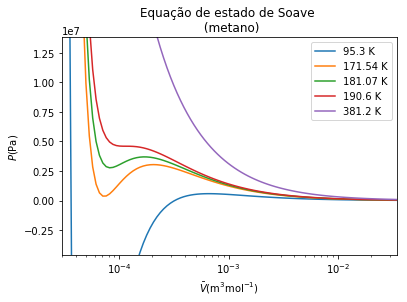

In [156]:
for i in range(nT):
    plt.plot(seqVm,listP[i],label=str(seqT[i])+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
    plt.ylabel(r'$P (\mathrm{Pa})$') #create labels to be displayed in y axis of the plot
    plt.xlabel(r'${V} (\mathrm{m^{3}mol^{-1}})$') #use matplotlib's  mathtext to create special symbols in the x label
    plt.title('Equação de estado de Soave \n (metano)') #create a title for the figure
    plt.ylim(-Pc,Pc*3)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
    plt.xlim(b,(R*Tc/Pc)*100) #define max and min limits of the x axis
    plt.xscale('log')
plt.legend()
plt.show()

## V eos

A equação de estado de Soave é dita cúbica pois pode ser re-escrita da seguinte forma:

$$Z^3-Z^2(1+B-uB)+Z(A+wB^2-uB-uB^2)-AB-wB^2-wB^3=0$$

> Reid, Prausnitz & Poling, 1987, pp 42, 43

Que é um polinômia de grau 3 (equação cúbica) na variável Z

em que 

$$Z=\frac{PV}{RT}$$

Vamos implementar essa forma polinomial e resolver usando um método de solução de polinômios


In [157]:
def V_cubic(T,P):
    a=f_a(T)
    A=a*P/(R**2*T**2)
    B=b*P/(R*T)
    c3=1
    c2=-(1+B-u*B)
    c1=(A+w*B**2-u*B-u*B**2)
    c0=-A*B-w*B**2-w*B**3
    coeffs=(c3,c2,c1,c0)
#     print('coeffs:',coeffs)
    Z=np.roots(coeffs)
    nZ=len(Z)

    listV_raw=[ Zi*R*T/P for Zi in Z]

    listV_good=[]    
    
    imag_tol = 1e-11
    
    for Vi in listV_raw:
        if (abs(Vi.imag) < imag_tol) and (Vi.real > b):
            listV_good.append(Vi.real)
    
    nV_good = len(listV_good)
    
    vL=min(listV_good)
    vV=max(listV_good)
    zL=P*vL/(R*T)
    zV=P*vV/(R*T)
    return vL, vV, zL,zV,nV_good

In [158]:
T0=273.15
P0=1.01325e5
print( V_cubic(T0,P0*10) )
print( V_cubic(T0,P0*100) )
print( V_cubic(T0,P0*1000) )
print( V_cubic(T0/2,P0) )
print( V_cubic(T0/4,P0) )
print( V_cubic(T0/8,P0) )
print( V_cubic(T0/8,P0*10) )
print( V_cubic(T0/8,P0*100) )

print( V_cubic(T0,P0/10) )
print( V_cubic(T0,P0/100) )
print( V_cubic(T0,P0/100) )
print( V_cubic(T0,P0/1000) )
print( V_cubic(T0,P0/10000) )

(0.0021878294226813496, 0.0021878294226813496, 0.97615514122665858, 0.97615514122665858, 1)
(0.0001793647183114763, 0.0001793647183114763, 0.80028081768749459, 0.80028081768749459, 1)
(4.4087869060909547e-05, 4.4087869060909547e-05, 1.967091200226661, 1.967091200226661, 1)
(4.2973664625726785e-05, 0.010994695314128862, 0.0038347563321771022, 0.9811119866880682, 3)
(3.3421231252545952e-05, 0.0049737773056450461, 0.0059646892714906941, 0.88767035270446326, 3)
(3.1252964235590954e-05, 3.1252964235590954e-05, 0.011155437037593346, 0.011155437037593346, 1)
(3.1246245748855888e-05, 3.1246245748855888e-05, 0.11153038940081829, 0.11153038940081829, 1)
(3.1182654223466688e-05, 3.1182654223466688e-05, 1.113034057290436, 1.113034057290436, 1)
(0.22407352023439525, 0.22407352023439525, 0.99976038589649241, 0.99976038589649241, 1)
(2.241218536722366, 2.241218536722366, 0.99997603768978527, 0.99997603768978527, 1)
(2.241218536722366, 2.241218536722366, 0.99997603768978527, 0.99997603768978527, 1)
(2

* cálculo em sequência

In [159]:
seqT=Tc*np.array([.5,.90,.95,1,2])
nT=len(seqT)

listVm_L=[]
listVm_V=[]

nP=10
Pmin=1e-5
Pmax=Pc*3

lg_pmin=np.log10(Pmin)
lg_pmax=np.log10(Pmax)

#seqP = np.logspace(lg_pmin,lg_pmax,nP)
seqP = np.linspace(Pmin,Pmax,nP)

for T in seqT:
    seqVmi_L=np.zeros(nP)
    seqVmi_V=np.zeros(nP)
    seqZi_L=np.zeros(nP)
    seqZi_V=np.zeros(nP)
    seqnVi=np.zeros(nP)
    for i in range(nP):
        seqVmi_L[i],seqVmi_V[i],seqZi_L[i],seqZi_V[i],seqnVi[i] = V_cubic(T,seqP[i])
    listVm_L.append( seqVmi_L )
    listVm_V.append( seqVmi_V )

* plot

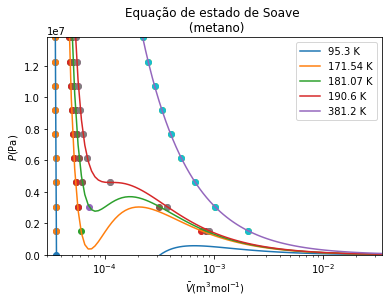

In [160]:
for i in range(nT):
    #do cálculo de isotermas
    plt.plot(seqVm,listP[i],label=str(seqT[i])+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
    #do cálculo de volumes
    plt.scatter(listVm_L[i],seqP)
    plt.scatter(listVm_V[i],seqP)
    
    plt.ylabel(r'$P (\mathrm{Pa})$') #create labels to be displayed in y axis of the plot
    plt.xlabel(r'${V} (\mathrm{m^{3}mol^{-1}})$') #use matplotlib's  mathtext to create special symbols in the x label
    plt.title('Equação de estado de Soave \n (metano)') #create a title for the figure
    plt.ylim(0,Pc*3)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
    plt.xlim(b,(R*Tc/Pc)*100) #define max and min limits of the x axis
    plt.xscale('log')
plt.legend()
plt.show()

# Faixa de busca para pressão de saturação
(metodologia baseada em Topliss, Dimitrelis & Prausnitz, 1988)

Sabendo que a pressão de saturação está na faixa de pressão para a qual há três raízes de volume, a região de busca pode ser definida pelo cálculo do mínimo e máximo locais da isoterma:

dado $T$, buscar $V^*$ tal que $\left(\frac{\partial P}{\partial V}\right)_T=0$

Filtram-se apenas os valores físicos: $V^*$ entre $b$ e $\infty$

$$ \left( \frac{\partial P}{\partial V} \right) _T= 0$$

usando a equação de Soave, obtemos a seguinte expressão para essa derivada parcial

$$\frac{\partial{P}}{\partial{V}} = - \frac{R T}{\left(V - b\right)^{2}} - \frac{a \left(- 2 V - b u\right)}{\left(V^{2} + V b u + b^{2} w\right)^{2}}$$

como buscamos os valores de V para os quais a expressão dá zero, podemos multiplicar ambos os lados da equação pelos denominadores de cada termo, obtendo assim

$$- R T \left(V^{2} + V b u + b^{2} w\right)^{2} - a \left(- 2 V - b u\right) \left(V - b\right)^{2} = 0$$

realizando as operações distributivas, potências de somas e coletando os coeficientes de iguais potências de V chegamos a representação polinomial

$$V^{4} - \frac{V^{3}}{R T} \left(- 2 R T b u + 2 a\right) - \frac{V^{2}}{R T} \left(- R T b^{2} u^{2} - 2 R T b^{2} w + a b u - 4 a b\right) - \frac{V}{R T} \left(- 2 R T b^{3} u w - 2 a b^{2} u + 2 a b^{2}\right) - \frac{1}{R T} \left(- R T b^{4} w^{2} + a b^{3} u\right) = 0$$

A qual pode ser convenientemente expressa por coeficientes $c_0$, $c_1$, $c_2$, $c_3$ e $c_4$.

$$ c_4V^4 + c_3 V^3+c_2V^2+c_1 V+c_0=0$$

em que

$c_4 = 1$

$c_3 = (-2RTbu + 2a)/(-RT)$

$c_2 = (-RTb^2u^2 - 2RTb^2w + abu - 4ab)/(-RT)$

$c_1 = (-2RTb^3uw - 2ab^2u + 2ab^2)/(-RT)$

$c_0 = (-RTb^4w^2 + ab^3u)/(-RT)$

In [161]:
def Plimits(T):
    #cálculo dos limites para busca de pressão de saturação
    
    #calcular coeficientes da representação polinomial
    a=f_a(T)
    c4 = 1
    c3 = (-2*R*T*b*u + 2*a)/(-R*T)
    c2 = (-R*T*b**2*u**2 - 2*R*T*b**2*w + a*b*u - 4*a*b)/(-R*T)
    c1 = (-2*R*T*b**3*u*w - 2*a*b**2*u + 2*a*b**2)/(-R*T)
    c0 = (-R*T*b**4*w**2 + a*b**3*u)/(-R*T)
    
    #resolver raízes com a função roots
    coefs = (c4,c3,c2,c1,c0)
    plateaus = np.roots(coefs)

    #    filtrar apenas os valores físicos (V real e maior que b)
    listV_raw= plateaus

    listV_good=[]    
    
    imag_tol = 1e-11
    
    for Vi in listV_raw:
        if (abs(Vi.imag) < imag_tol) and (Vi.real > b):
            listV_good.append(Vi.real)
    
    nplateeaus_good = len(listV_good)    
    
    if nplateeaus_good >= 1:
        Vli = min(listV_good)
        Vvi = max(listV_good)

        #calcular a pressão correspondente a cada raiz de volume selecionada
        Psup = P_soave(T,Vvi)
        Pinf = P_soave(T,Vli)

        #definir com limite superior uma pressão ligeiramente abaixo da pressão limite superior
        #e ligeiramente acima da pressão limite inferior para garantir que existam três volumes nas condições teste
        #não levar pressão negativa para o cálculo de pressão de saturação
        Psupi=Psup*.999999
    
        if Pinf > 0:
            Pinfi = Pinf*1.000001
        else:
            Pinfi = 1e-14
            
    elif nplateeaus_good==0:
        #não achamos faixa de busca
        Vli=None
        Vvi=None
        Psupi=None
        Pinfi=None
        
    return nplateeaus_good,Vli,Vvi,Pinfi,Psupi

* testes

In [162]:
nPlim,Vli,Vvi,Pinfi,Psupi=Plimits(120)
print("nPlim:",nPlim)
print("Vli:",Vli)
print("Vvi:",Vvi)
print("Psupi:",Psupi)
print("Pinfi:",Pinfi)

nPlim,Vli,Vvi,Pinfi,Psupi=Plimits(170)
print("nPlim:",nPlim)
print("Vli:",Vli)
print("Vvi:",Vvi)
print("Psupi:",Psupi)
print("Pinfi:",Pinfi)

nPlim,Vli,Vvi,Pinfi,Psupi=Plimits(220)
print("nPlim:",nPlim)
print("Vli:",Vli)
print("Vvi:",Vvi)
print("Psupi:",Psupi)
print("Pinfi:",Pinfi)

nPlim: 2
Vli: 5.12869412052e-05
Vvi: 0.000451189451291
Psupi: 1059459.53909
Pinfi: 1e-14
nPlim: 2
Vli: 7.18570675713e-05
Vvi: 0.000211603586191
Psupi: 2951298.46556
Pinfi: 1e-14
nPlim: 0
Vli: None
Vvi: None
Psupi: None
Pinfi: None


* validação gráfica

In [130]:
seqVlilim=np.zeros(nT)
seqVvilim=np.zeros(nT)
seqPsupilim=np.zeros(nT)
seqPinfilim=np.zeros(nT)
nPlim=np.zeros(nT)

for i in range(nT):
    nPlim[i],seqVlilim[i],seqVvilim[i],seqPinfilim[i],seqPsupilim[i]=Plimits(seqT[i])
    print("nPlim:",nPlim[i])

nPlim: 2.0
nPlim: 2.0
nPlim: 2.0
nPlim: 2.0
nPlim: 0.0


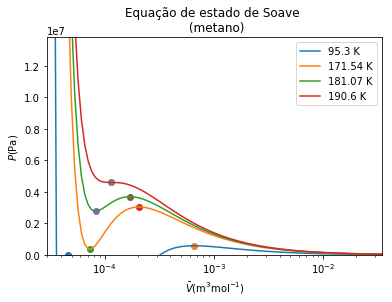

In [131]:
for i in range(nT):
    if nPlim[i]>0:
        plt.semilogx(seqVm,listP[i],label=str(seqT[i])+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
        plt.ylabel(r'$P (\mathrm{Pa})$') #create labels to be displayed in y axis of the plot
        plt.xlabel(r'${V} (\mathrm{m^{3}mol^{-1}})$') #use matplotlib's  mathtext to create special symbols in the x label
        plt.title('Equação de estado de Soave \n (metano)') #create a title for the figure
        plt.ylim(0,Pc*3)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
        plt.xlim(b,(R*Tc/Pc)*100) #define max and min limits of the x axis
        plt.scatter(seqVlilim[i],seqPinfilim[i])
        plt.scatter(seqVvilim[i],seqPsupilim[i])
plt.legend();

## G residual

$$A^{\mathrm{RES}} = - R T \ln{\left (\frac{V}{V^{IG}} \right )} - R T \ln{\left (\frac{1}{Z} \left(- B + Z\right) \right )} + \frac{a}{b \sqrt{u^{2} - 4 w}} \ln{\left (\frac{B \left(u - \sqrt{u^{2} - 4 w}\right) + 2 Z}{B \left(u + \sqrt{u^{2} - 4 w}\right) + 2 Z} \right )}$$

> Reid, Prausnitz & Poling, 1987, pp 102

logo, como $G = A+PV$

temos que $G^{IG} = A^{IG}+PV^{IG}$

logo

$$G^\mathrm{RES} = A^\mathrm{RES}+P(V-V^{IG})$$

$$G^{\mathrm{RES}} = R T (Z-1) - R T \ln{\left ( - B + Z \right )} + \frac{a}{b \sqrt{u^{2} - 4 w}} \ln{\left (\frac{B \left(u - \sqrt{u^{2} - 4 w}\right) + 2 Z}{B \left(u + \sqrt{u^{2} - 4 w}\right) + 2 Z} \right )}$$



In [132]:
def Gres_RT(T,P,Z):    
    a=f_a(T)
    A=a*P/(R**2*T**2)
    B=b*P/(R*T)
    T1=A/(B*(u**2-4*w)**.5)
    T2=(-1)
    T3=2*Z+B*(u+(u**2-4*w)**.5)
    T4=2*Z+B*(u-(u**2-4*w)**.5)
    Gres_RT_TPZ = (Z-1)-np.log(Z-B)+T1*T2*np.log(T3/T4)
    return Gres_RT_TPZ

## o critério de equilíbrio

$$\mu_i^L=\mu_i^V$$

no caso do puro, $G=\mu_i$

$$G^\mathrm{L}=G^\mathrm{V}$$

usando uma mesma referência

$$G^\mathrm{L}-G^\mathrm{IG}=G^\mathrm{V}-G^\mathrm{IG}$$

$$ G^\mathrm{RES,L}=G^\mathrm{RES,V} $$

ou com as variáveis adimensionadas dividinto pelo produto $(RT)$

$$ \frac{G^\mathrm{RES,L}}{RT}=\frac{G^\mathrm{RES,V}}{RT} $$

* verificar existẽncia de solução em uma temperatura teste

In [164]:
T_test=seqT[1]
nVlim,Vli,Vvi,Pinfi,Psupi=Plimits(T_test)

nP=100
Gres_RT_L=np.zeros(nP)
Gres_RT_V=np.zeros(nP)

seqP = np.linspace(Pinfi,Psupi,nP)
Vmi_L=np.zeros(nP)
Vmi_V=np.zeros(nP)
Z_L=np.zeros(nP)
Z_V=np.zeros(nP)
nV=np.zeros(nP)
for i in range(nP):
    Vmi_L[i],Vmi_V[i],Z_L[i],Z_V[i],nV[i] = V_cubic(T_test,seqP[i])
    Gres_RT_L[i] = Gres_RT(T_test,seqP[i],Z_L[i])
    Gres_RT_V[i] = Gres_RT(T_test,seqP[i],Z_V[i])

* plot

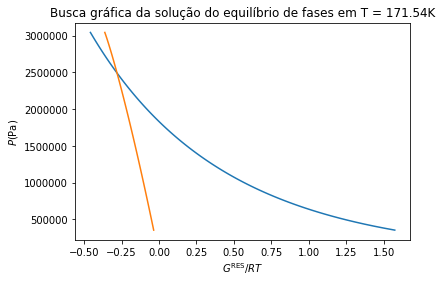

In [167]:
plt.plot(Gres_RT_L,seqP)
plt.plot(Gres_RT_V,seqP)

plt.xlabel(r'$G^\mathrm{RES}/RT$') #create labels to be displayed in y axis of the plot
plt.ylabel(r'$P (\mathrm{Pa})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Busca gráfica da solução do equilíbrio de fases em T = '+str(T_test)+'K') #create a title for the figure

plt.show()

## Pressão de saturação

In [135]:
def Psat(T):
    
    def RES(P):
        vL,vV,zL,zV,nV=V_cubic(T,P)
        Gres_RT_L=Gres_RT(T,P,zL)
        Gres_RT_V=Gres_RT(T,P,zV)
        return Gres_RT_L-Gres_RT_V

    nlim,Vli,Vvi,Psupi,Pinfi=Plimits(T)
    P0a=Pinfi
    P0b=Psupi
    
    Psati=opt.bisect(RES,P0a,P0b)
    
    return Psati

T_test=seqT[1]
Psat_test = Psat(T_test)
Psat_test

2492049.142828395

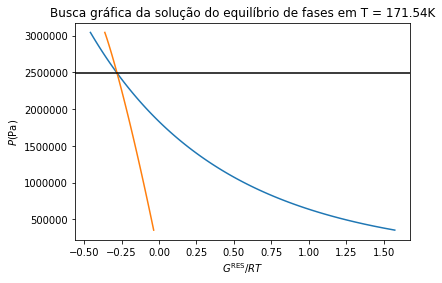

In [168]:
plt.plot(Gres_RT_L,seqP)
plt.plot(Gres_RT_V,seqP)
plt.axhline(Psat_test,color='k')

plt.xlabel(r'$G^\mathrm{RES}/RT$') #create labels to be displayed in y axis of the plot
plt.ylabel(r'$P (\mathrm{Pa})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Busca gráfica da solução do equilíbrio de fases em T = '+str(T_test)+'K') #create a title for the figure

plt.show()

* cálculo em sequência

In [137]:
nTP=100
Tseq=np.linspace(30,Tc*.99,nTP)
Pseq=np.zeros(nTP)
for i in range(nTP):
    Pseq[i]=Psat(Tseq[i])

* plot

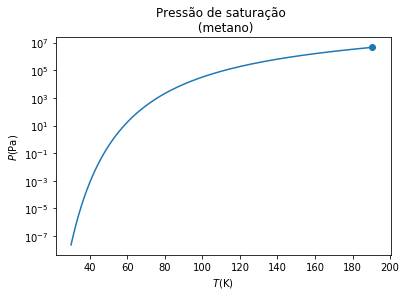

In [170]:
plt.plot(Tseq,Pseq)
plt.scatter(Tc,Pc)
plt.yscale('log')

plt.xlabel(r'$T(\mathrm{K})$') #create labels to be displayed in y axis of the plot
plt.ylabel(r'$P (\mathrm{Pa})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Pressão de saturação \n (metano)') #create a title for the figure

plt.show()

## envelope

In [148]:
#envelope de fases no plano PxV
nTP=1000
Tseq=np.linspace(30,Tc*.999,nTP)
Pseq=np.zeros(nTP)
VL_seq=np.zeros(nTP)
VV_seq=np.zeros(nTP)
ZL_seq=np.zeros(nTP)
ZV_seq=np.zeros(nTP)
nV_seq=np.zeros(nTP)
for i in range(nTP):
    Pseq[i]=Psat(Tseq[i])
    VL_seq[i],VV_seq[i],ZL_seq[i],ZV_seq[i],nV_seq=V_cubic(Tseq[i],Pseq[i])

#amarração de VL VV em equilíbrio das isotermas
Pseq2=np.zeros(nT)
VL_seq2=np.zeros(nT)
VV_seq2=np.zeros(nT)
ZL_seq2=np.zeros(nT)
ZV_seq2=np.zeros(nT)
nV_seq2=np.zeros(nT)    
for i in range(nT-2):
    Pseq2[i]=Psat(seqT[i])
    VL_seq2[i],VV_seq2[i],ZL_seq2[i],ZV_seq2[i],nV_seq2=V_cubic(seqT[i],Pseq2[i])

In [149]:
vc = V_cubic(Tc,Pc)
vc

(0.00011275026723619101,
 0.00011275026723619101,
 0.32722620299824395,
 0.32722620299824395,
 1)

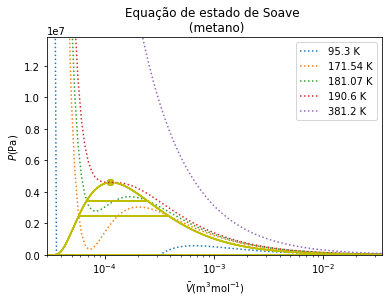

In [150]:
for i in range(nT):
    plt.plot(seqVm,listP[i],label=str(seqT[i])+' K',ls=':') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
    plt.ylabel(r'$P (\mathrm{Pa})$') #create labels to be displayed in y axis of the plot
    plt.xlabel(r'${V} (\mathrm{m^{3}mol^{-1}})$') #use matplotlib's  mathtext to create special symbols in the x label
    plt.title('Equação de estado de Soave \n (metano)') #create a title for the figure
    plt.ylim(0,Pc*3)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
    plt.xlim(b,(R*Tc/Pc)*100) #define max and min limits of the x axis
    plt.xscale('log')
    
    plt.plot(VL_seq,Pseq, color='y')
    plt.plot(VV_seq,Pseq, color='y')
    
    for j in range(nT-2):
        plt.plot([VL_seq2[j],VV_seq2[j]],[Pseq2[j],Pseq2[j]],color='y')
        
    plt.scatter(vc[0],Pc,color='y')
      
plt.legend()

plt.savefig("envelope de fases P versus V.png")

plt.show()

# Conclusão

A solução do equilibrio liquido vapor por eos não é simples. há que se preocupar com solução trivial (GresL=GresV | vl=vv; eos retornando uma unica raiz real; dificuldade de convergencia dos metodo numericos...)



# Referências

>* Reid, R. C., Prausnitz, J. M. and Poling, B. E., 1987. The Properties of Gases and Liquids. 4th ed., McGraw-Hill. [ISBN: 0070517991, 9780070517998
](https://books.google.com.br/books?id=AcRTAAAAMAAJ)

>* Smith, J. M., van Ness, H. C. and Abbott, M. M., 2007. Introdução a termodinâmica da engenharia química. 7a ed., LTC. [ISBN: 8521615531, 9788521615538](https://books.google.com.br/books?id=TzeQPgAACAAJ)


>* Topliss, R J., Dimitrelis D., and Prausnitz, J. M., 1988, “Computational Aspects of a Non-Cubic Equation of State for Phase-Equilibrium Calculations. Effect of Density-Dependent Mixing Rules.” Computers & Chemical Engineering 12 (5): 483–89. [doi:10.1016/0098-1354(88)85067-1](http://dx.doi.org/10.1016/0098-1354(88)85067-1)

>* [numpy.roots ](https://docs.scipy.org/doc/numpy/reference/generated/numpy.roots.html)
>* [scipy.optimize.bisect](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html)